In [5]:
# CPSC 66 - Machine Learning
# Final Project   
# Group Memebers: Sidhika Tripathee, Ali Baratta and Ghazi Randhawa

In [1]:
#import all the libraries needed
from math import sqrt, ceil
import numpy as np
import pandas as pd
from sklearn import datasets,preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDClassifier
import matplotlib
from sklearn import linear_model, decomposition
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# pipeline tools for cross validation, tuning, and validation curves
from sklearn.model_selection import StratifiedKFold, GridSearchCV, validation_curve,TimeSeriesSplit,train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.multiclass import OneVsRestClassifier
#ML algorithms
from sklearn import ensemble, datasets, svm, metrics, neighbors, utils
from sklearn.ensemble import RandomForestClassifier

import scipy.stats


10.414814814814815
2.750829778790263


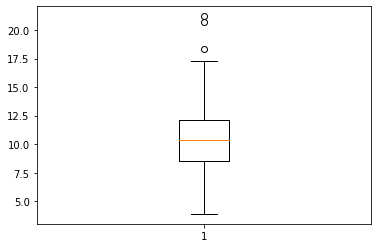

(0.0, 60.0)

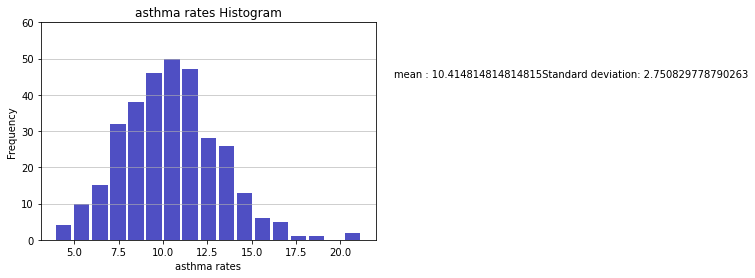

In [2]:
data_orig = pd.read_csv('datasetdone.csv') # open the csv file to see the data
data=data_orig.copy()
#Find a suitable cutt-off value for the asthma rates to assign a label.
mean=np.mean(data["asthma_rates"])
print(mean)
sd=np.std(data["asthma_rates"])
print(sd)

#draw a box plot
plt.boxplot(data["asthma_rates"])
plt.show()

#Draw a histogram
n, bins, patches = plt.hist(x=data["asthma_rates"], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('asthma rates')
plt.ylabel('Frequency')
plt.title('asthma rates Histogram')
print_statement='mean : ' + str(mean)+'Standard deviation: ' + str(sd)
plt.text(23, 45, print_statement)
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

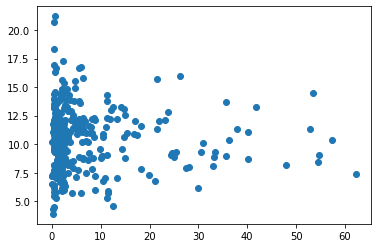

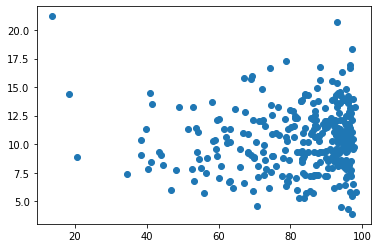

In [3]:
#draw scatter plots to check for correlations in data
plt.scatter(data['black'], data['asthma_rates'])
plt.show()
plt.scatter(data['white'], data['asthma_rates'])
plt.show()

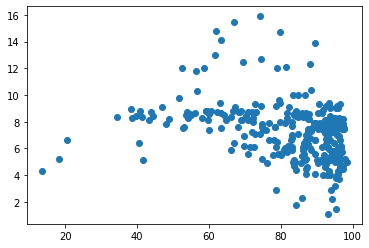

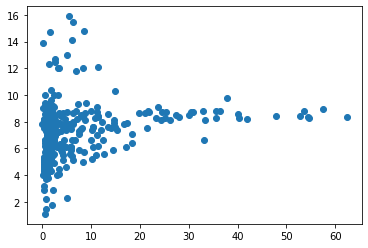

In [4]:
plt.scatter(data['white'], data['pm2.5'])
plt.show()

plt.scatter(data['black'], data['pm2.5'])
plt.show()

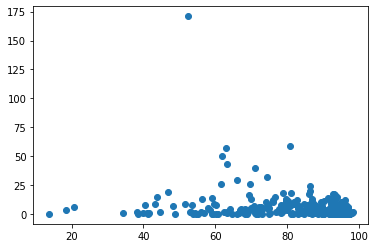

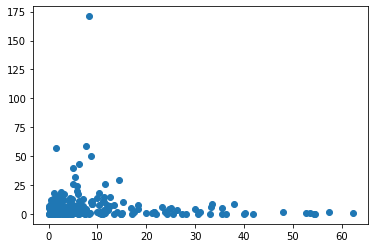

In [5]:
plt.scatter(data['white'], data['num_waste_facilities'])
plt.show()
plt.scatter(data['black'], data['num_waste_facilities'])
plt.show()

## Change in labeling in following cell:

In [6]:
#Create two classes using the following cutoff points
data=data_orig.copy()
lim=mean+0.5*sd
labels=[]
n_labels=[0,0]
#go through each example and set the correct label
for i in range(len(data["asthma_rates"])):
    if (data["asthma_rates"][i] >= lim):
        n_labels[1] += 1
        labels.append("HR") #high risk
    elif (data["asthma_rates"][i] < lim):
        n_labels[0] += 1
        labels.append("LR") #normal risk

#Remove asthma_rates(label)
data.pop("asthma_rates")

#remove state and county names
data.pop('State')
data.pop('County')


0        Alameda
1         Alpine
2         Amador
3          Butte
4      Calaveras
         ...    
319      Webster
320       Wetzel
321         Wirt
322         Wood
323      Wyoming
Name: County, Length: 324, dtype: object

In [7]:
def standardizer(X):
    """
    This function performs standardization on data inputed using StandardScaler
    """
       
    columns=X.columns
    scale= StandardScaler()
    scaled_data = preprocessing.scale(X) 
    X = pd.DataFrame(scaled_data, columns = columns)
    return X
    

In [8]:
def pcaer(X):
    pca = PCA(.95)
    pca.fit(X)
    X = pca.transform(X)
    return X

In [9]:
def printWeights(features, weights):
    """
    Pretty-print the model weights.
    features contains the name of each feature and weights is an array type of the same length.
    You may need to modify this function depending on your implementation
    """
    if "bias" not in features:
        features = list(features)+["bias"]
    print("\t%30s %10s" % ("Feature", "Weight"))
    for i in range(len(features)):
        print("\t%30s %10.5f" % (features[i], weights[i]))

Accuracy for SKlearn SGDClassifier: 73.85%
Coefficients and intercept for SKlearn SGDClassifier: 
	                       Feature     Weight
	          num_waste_facilities   -0.11800
	                         pm2.5   -0.37893
	                         white   -4.67525
	                         black   -0.34090
	                         asian   -0.13375
	                      hispanic   -0.45350
	               native_american   -0.27280
	                         other   -0.12630
	                    population 1294.72950
	                          bias   -0.05650


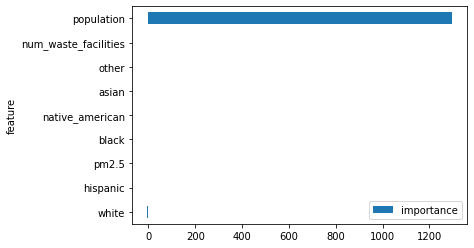

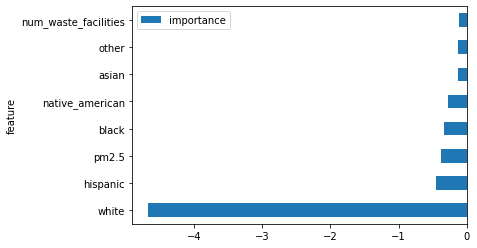

In [10]:
alpha = .001 #learning rate

data_processed_orig=data

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(data_processed_orig, labels, test_size=0.4, random_state=0)

X_train=X_train_orig.copy()
y_train=y_train_orig.copy()
X_test=X_test_orig.copy()
y_test=y_test_orig.copy()

"""
 Create a logistic regression SGDClassifier with no hypertuning
"""

sgd = SGDClassifier(loss='log', max_iter=1,shuffle=False, tol=None, penalty='none', learning_rate='constant', eta0 = alpha)
sgd.fit(X_train,y_train)

#SGD model weights:
print("Accuracy for SKlearn SGDClassifier: %0.2f%%" % (sgd.score(X_test,y_test)*100))
print("Coefficients and intercept for SKlearn SGDClassifier: ")
weights = list(sgd.coef_[0]) + list(sgd.intercept_) 
printWeights(X_train.columns,  weights)

#graph feature importance
log_reg_feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
log_reg_feature_importance['importance']= weights[:9]
log_reg_feature_importance = log_reg_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = log_reg_feature_importance.plot.barh(x='feature', y='importance')
plt.show()

#graph without population to show data better
log_reg_feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
log_reg_feature_importance['importance']= weights[:9]
log_reg_feature_importance.drop(log_reg_feature_importance.index[[8]],inplace=True)
log_reg_feature_importance = log_reg_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = log_reg_feature_importance.plot.barh(x='feature', y='importance')
plt.show()

In [14]:
#Normalize and use GridCV for log regression
X=data_processed_orig.copy()
y= labels.copy()

#create objects to use in pipeline
standard_scl = StandardScaler() #normalize data
pca = decomposition.PCA()
log_reg = linear_model.LogisticRegression(random_state=0)

#create pipeline
pipe = Pipeline(steps=[('standard_slc', standard_scl),
                           ('pca', pca),
                           ('logistic_reg', log_reg)])
#create parameters for each object
n_components = list(range(1,X.shape[1]+1,1)) #for PCA components, range from 1 to features length+1

C = np.logspace(-2, 1, 50) #c value in log_regression

#parameters dictionary
parameters = {'pca__n_components':n_components,
                      'logistic_reg__C':C}

#GridSearch
grid = GridSearchCV(pipe, parameters,cv=4)
grid.fit(X_train,y_train)


print("Score", grid.score(X_test,y_test))
print('Best C:', grid.best_estimator_.get_params()['logistic_reg__C'])
print('Best Number Of Components:', grid.best_estimator_.get_params()['pca__n_components'])
print()
print(grid.best_estimator_.get_params()['logistic_reg'])

Score 0.7384615384615385
Best C: 0.013257113655901088
Best Number Of Components: 4

LogisticRegression(C=0.013257113655901088, random_state=0)


In [15]:
# testing what the ouput would be if data is not standardized

#test code to normalize and use GridCV for log regression
X=data_processed_orig.copy()
y= labels.copy()

#create objects to use in pipeline
standard_scl = StandardScaler() #normalize data
pca = decomposition.PCA()
log_reg = linear_model.LogisticRegression(random_state=0)

#create pipeline
pipe = Pipeline(steps=[('pca', pca),
                      ('logistic_reg', log_reg)])
#create parameters for each object
n_components = list(range(1,X.shape[1]+1,1)) #for PCA components, range from 1 to features length+1

C = np.logspace(-2, 2, 50) #c value in log_regression

#parameters dictionary
parameters = {'pca__n_components':n_components,
                     'logistic_reg__C':C}

grid = GridSearchCV(pipe, parameters,cv=4)
grid.fit(X_train,y_train)
print("Score", grid.score(X_test,y_test))

print('Best C:', grid.best_estimator_.get_params()['logistic_reg__C'])
print('Best Number Of Components:', grid.best_estimator_.get_params()['pca__n_components'])
print()
print(grid.best_estimator_.get_params()['logistic_reg'])

Score 0.33076923076923076
Best C: 0.01
Best Number Of Components: 3

LogisticRegression(C=0.01, random_state=0)


Accuracy for SKlearn SGDClassifier: 73.85%
Coefficients and intercept for SKlearn SGDClassifier: 
	                       Feature     Weight
	          num_waste_facilities    0.01081
	                         pm2.5    0.08267
	                         white    0.02331
	                         black   -0.01967
	                         asian    0.01070
	                      hispanic    0.01944
	               native_american   -0.10698
	                         other    0.03591
	                    population    0.03933
	                          bias    0.83404


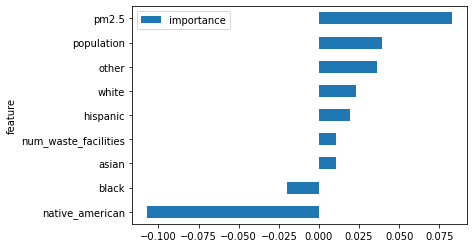

In [16]:
#creating logisitic regression classifier with best parameters determined by GridSearchCV
X_train=standardizer(X_train_orig.copy())
y_train=y_train_orig.copy()
X_test=standardizer(X_test_orig.copy())
y_test=y_test_orig.copy()
ideal_log_reg = linear_model.LogisticRegression(C=0.01, random_state=0)
ideal_log_reg.fit(X_train,y_train)

#SGD model weights:
print("Accuracy for SKlearn SGDClassifier: %0.2f%%" % (ideal_log_reg.score(X_test,y_test)*100))
print("Coefficients and intercept for SKlearn SGDClassifier: ")
weights = list(ideal_log_reg.coef_[0]) + list(ideal_log_reg.intercept_) 
printWeights(X_train.columns,  weights)

#graph feature importance
log_reg_feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
log_reg_feature_importance['importance']= weights[:9]
log_reg_feature_importance = log_reg_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = log_reg_feature_importance.plot.barh(x='feature', y='importance')
plt.show()

parameter	 train accurary	 test accuracy	
0.01 		 0.721 		 0.713 	
0.011 		 0.721 		 0.713 	
0.011 		 0.721 		 0.713 	
0.012 		 0.721 		 0.716 	
0.013 		 0.721 		 0.716 	
0.014 		 0.721 		 0.716 	
0.015 		 0.721 		 0.716 	
0.016 		 0.721 		 0.716 	
0.017 		 0.721 		 0.716 	
0.019 		 0.722 		 0.716 	
0.02 		 0.722 		 0.716 	
0.022 		 0.722 		 0.716 	
0.023 		 0.722 		 0.716 	
0.025 		 0.722 		 0.716 	
0.027 		 0.722 		 0.716 	
0.028 		 0.722 		 0.716 	
0.031 		 0.723 		 0.716 	
0.033 		 0.723 		 0.716 	
0.035 		 0.723 		 0.716 	
0.038 		 0.723 		 0.716 	
0.04 		 0.724 		 0.716 	
0.043 		 0.724 		 0.716 	
0.046 		 0.723 		 0.716 	
0.05 		 0.723 		 0.716 	
0.053 		 0.723 		 0.716 	
0.057 		 0.723 		 0.716 	
0.061 		 0.723 		 0.71 	
0.066 		 0.723 		 0.713 	
0.071 		 0.723 		 0.707 	
0.076 		 0.723 		 0.707 	
0.081 		 0.722 		 0.707 	
0.087 		 0.722 		 0.71 	
0.093 		 0.723 		 0.71 	
0.1 		 0.723 		 0.71 	
0.107 		 0.723 		 0.71 	
0.115 		 0.723 		 0.704 	
0.123 		 0.724 		 0.707 	
0.132 	

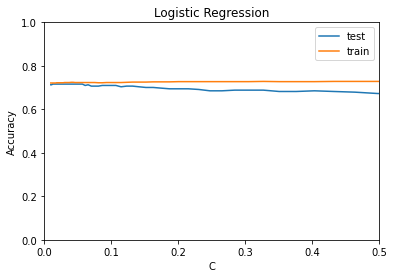

In [17]:
    #creating validation curves for log_reg
    X=standardizer(data_processed_orig.copy())
    y= labels.copy()
    param_range=np.logspace(-2, 1, 100)
    clf = linear_model.LogisticRegression(random_state=0)
    train,test = validation_curve(clf, X, y,param_name='C',param_range=param_range,cv=4)
    
    #calculate the average of the test and train scores from all folds
    sum_test=np.sum(test,axis=1)
    sum_train=np.sum(train,axis=1)
    avg_test=sum_test/4
    avg_train=sum_train/4
    print("parameter\t","train accurary\t","test accuracy\t")
    
    for i in range(len(param_range)):
        print(round(param_range[i],3),"\t\t",round(avg_train[i],3),"\t\t",round(avg_test[i],3),"\t")
   
    #graphing validation curves
    fig, ax = plt.subplots() 
    ax.set_ylim(0,1)
    ax.set_xlim(0,.5)
    ax.plot(param_range,avg_test,label="test")
    ax.plot(param_range,avg_train,label="train")
    ax.set_xlabel('C')  # Add an x-label to the axes.
    ax.set_ylabel("Accuracy")  # Add a y-label to the axes.
    ax.set_title("Logistic Regression")  # Add a title to the axes.    
    ax.legend()

In [18]:
#creating a pipeline for decision tree classifier
pipe_steps=[('scaler',StandardScaler()),('pca', pca),('decsT',DecisionTreeClassifier(random_state=0))]

pipeline = Pipeline(pipe_steps)

#parameters for gridsearch
check_params={'decsT__max_features': ['sqrt','auto','log2', None],
              'decsT__ccp_alpha':np.linspace(-1,1,5),
              'decsT__criterion':['gini','entropy'],
              'decsT__class_weight': ['balanced',None],
              'decsT__max_depth': np.arange(0,15)
               }

create_grid =GridSearchCV(pipeline,param_grid=check_params,cv=4)
create_grid.fit(X_train,y_train)

print("score for 4 fold CV := %3.2f" %(create_grid.score(X_test,y_test)))
print("!!! best fit parameters from GridSearchCV !!!!")
print(create_grid.best_params_)

score for 4 fold CV := 0.74
!!! best fit parameters from GridSearchCV !!!!
{'decsT__ccp_alpha': 0.5, 'decsT__class_weight': 'balanced', 'decsT__criterion': 'gini', 'decsT__max_depth': 1, 'decsT__max_features': 'sqrt'}


In [19]:
#without the Standard Scalar just to check

pipe_steps=[('pca', pca),('decsT',DecisionTreeClassifier(random_state=0))]


check_params={'decsT__max_features': ['int','float','sqrt','auto','log2',None],
              'decsT__ccp_alpha':np.linspace(-1,1,5),
              'decsT__criterion':['gini','entropy'],
              'decsT__class_weight': ['balanced',None],
              'decsT__max_depth': np.arange(0,15)
               }
pipeline = Pipeline(pipe_steps)

create_grid =GridSearchCV(pipeline,param_grid=check_params,cv=4)
create_grid.fit(X_train,y_train)
print("score for 4 fold CV := %3.2f" %(create_grid.score(X_test,y_test)))
print("!!! best fit parameters from GridSearchCV !!!!")
print(create_grid.best_params_)


score for 4 fold CV := 0.73
!!! best fit parameters from GridSearchCV !!!!
{'decsT__ccp_alpha': 0.0, 'decsT__class_weight': None, 'decsT__criterion': 'gini', 'decsT__max_depth': 1, 'decsT__max_features': 'sqrt'}


We see that we do not want to class balance, and that the most important feature seems to max_depth. We would therefore want to focus on the max_depth and finetune that through validation curves. The best decision criteria seems to be entropy. Standardizing the data seems to help.

parameter	 train accurary	 test accuracy	
1 		 0.713 		 0.713 	
2 		 0.721 		 0.664 	
3 		 0.75 		 0.623 	
4 		 0.786 		 0.608 	
5 		 0.818 		 0.438 	
6 		 0.854 		 0.552 	
7 		 0.891 		 0.522 	
8 		 0.926 		 0.469 	
9 		 0.953 		 0.519 	
10 		 0.974 		 0.503 	
11 		 0.986 		 0.475 	
12 		 0.993 		 0.494 	
13 		 0.998 		 0.506 	
14 		 0.999 		 0.485 	
15 		 0.999 		 0.488 	
16 		 1.0 		 0.481 	
17 		 1.0 		 0.481 	
18 		 1.0 		 0.481 	
19 		 1.0 		 0.481 	
20 		 1.0 		 0.481 	
21 		 1.0 		 0.481 	
22 		 1.0 		 0.481 	
23 		 1.0 		 0.481 	
24 		 1.0 		 0.481 	
25 		 1.0 		 0.481 	
26 		 1.0 		 0.481 	
27 		 1.0 		 0.481 	
28 		 1.0 		 0.481 	
29 		 1.0 		 0.481 	
30 		 1.0 		 0.481 	
31 		 1.0 		 0.481 	
32 		 1.0 		 0.481 	
33 		 1.0 		 0.481 	
34 		 1.0 		 0.481 	
35 		 1.0 		 0.481 	
36 		 1.0 		 0.481 	
37 		 1.0 		 0.481 	
38 		 1.0 		 0.481 	
39 		 1.0 		 0.481 	
40 		 1.0 		 0.481 	
41 		 1.0 		 0.481 	
42 		 1.0 		 0.481 	
43 		 1.0 		 0.481 	
44 		 1.0 		 0.481 	
45 		 1.0 		 0

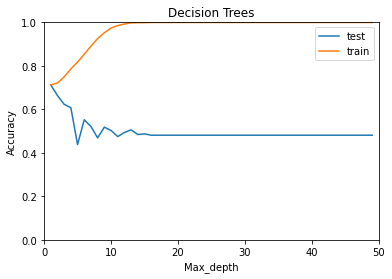

In [20]:
#Draw validation curves for the Decision Tree classifier

X=standardizer(data_processed_orig.copy())
y= labels.copy()
param_range=np.arange(1, 50)
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=0), param_name="max_depth",
    X=X,
    y=y,
    param_range=param_range, cv=4, scoring="accuracy"
)

#calculate the average of the test and train scores from all folds
sum_test=np.sum(test_scores,axis=1)
sum_train=np.sum(train_scores,axis=1)
avg_test=sum_test/4
avg_train=sum_train/4


print("parameter\t","train accurary\t","test accuracy\t")

for i in range(len(param_range)):
    print(param_range[i],"\t\t",round(avg_train[i],3),"\t\t",round(avg_test[i],3),"\t")
    
fig, ax = plt.subplots() 

ax.set_ylim(0,1)
ax.set_xlim(0,50)
ax.plot(param_range,avg_test,label="test")
ax.plot(param_range,avg_train,label="train")
ax.set_xlabel('Max_depth')  # Add an x-label to the axes.
ax.set_ylabel("Accuracy")  # Add a y-label to the axes.
ax.set_title("Decision Trees")  # Add a title to the axes.    
ax.legend()


It seems like our graph overfits pretty quickly.

train score:  0.9226804123711341
test_score:  0.6076923076923076


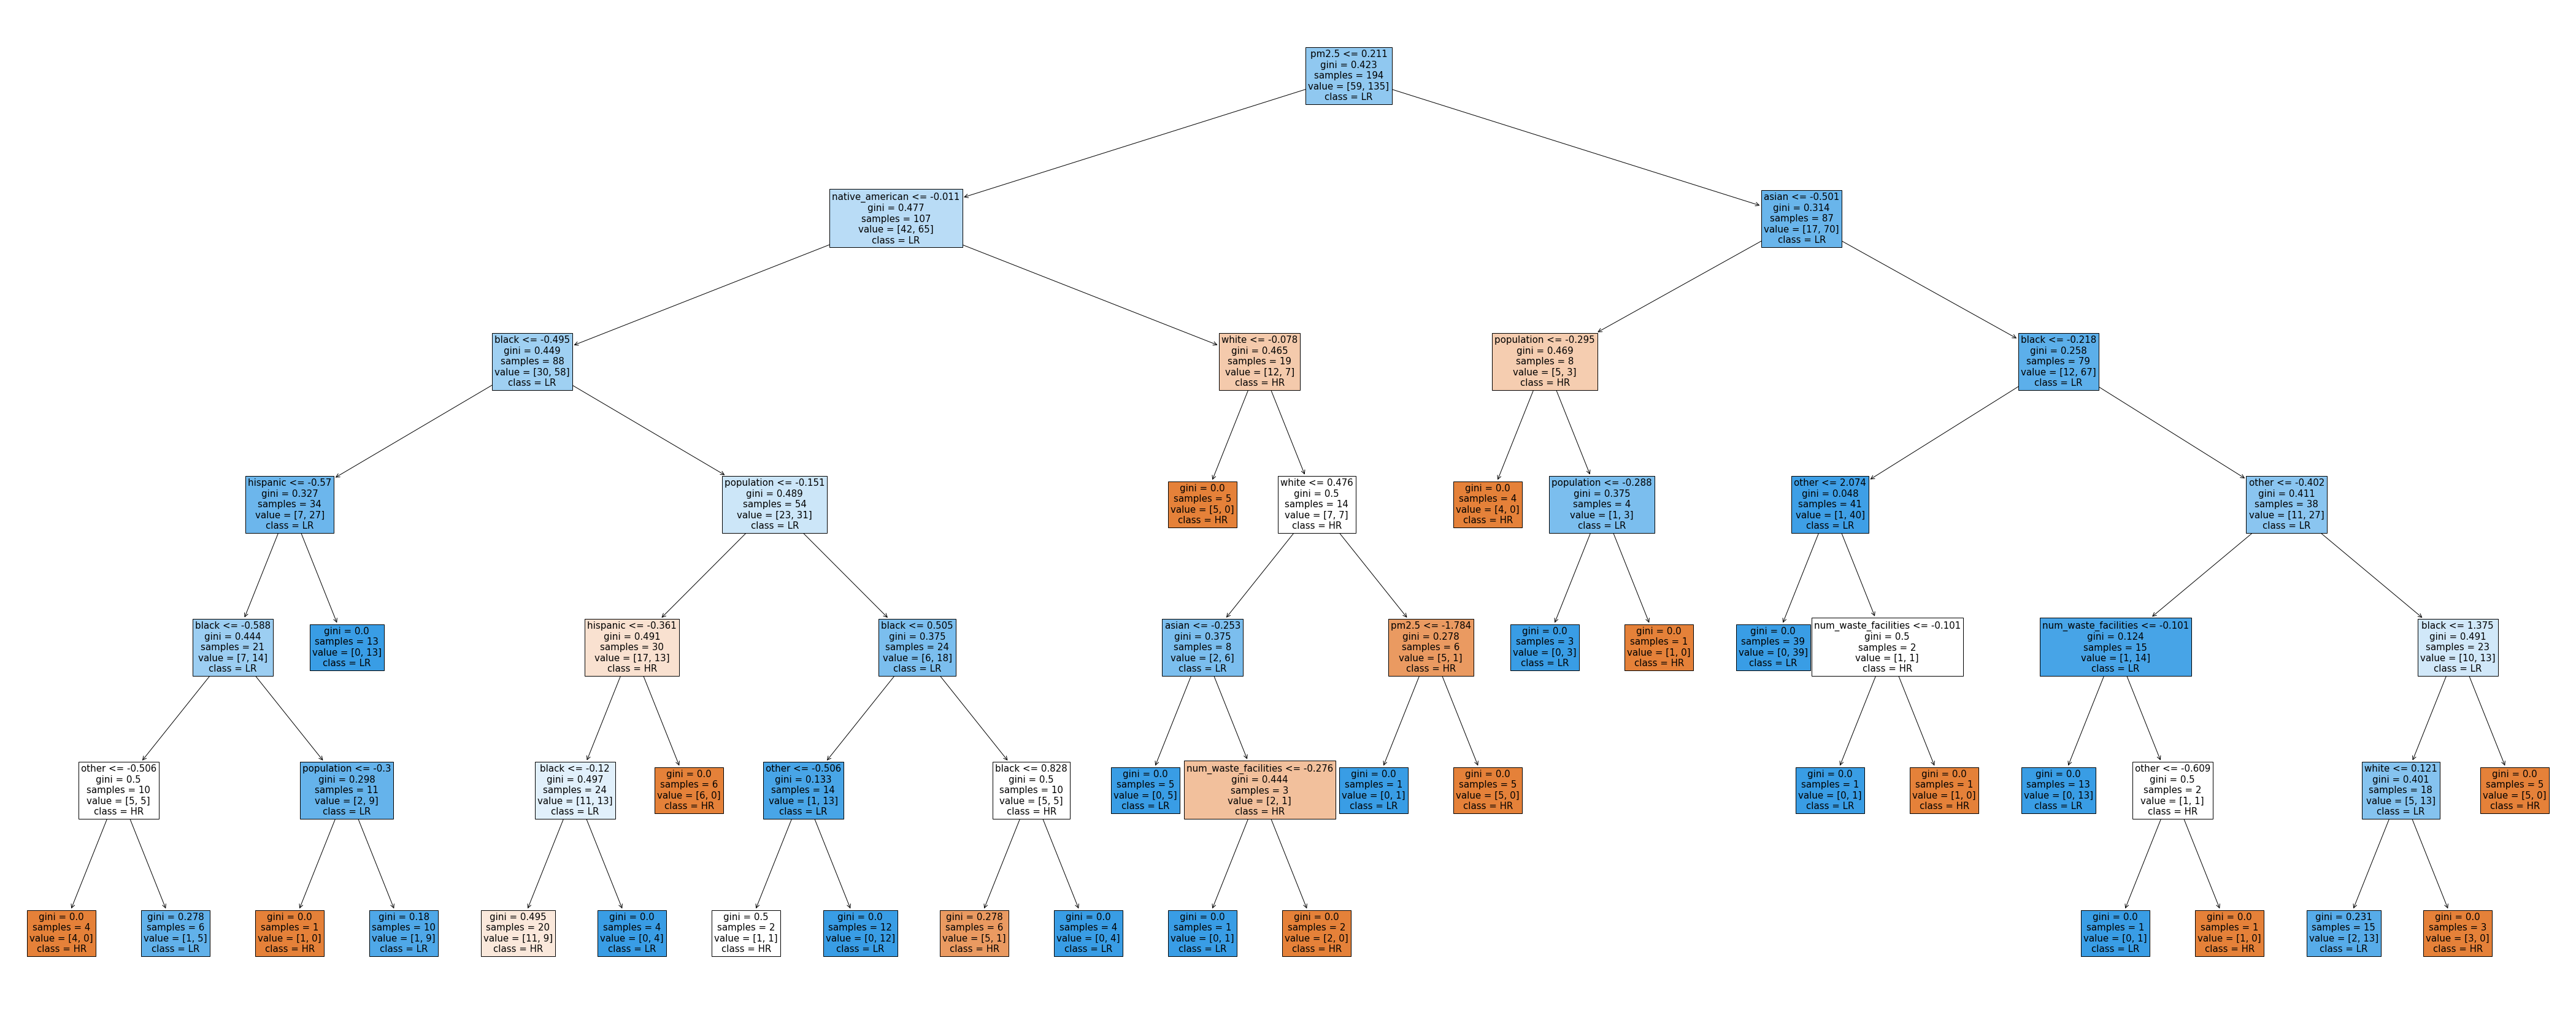

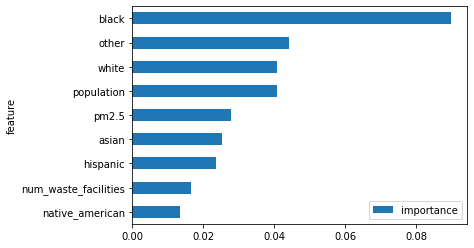

In [21]:
#we train an ideal Decision tree and display it's feature importance graphs.
ideal_DecsTree=DecisionTreeClassifier(max_depth=6,random_state=0)
ideal_DecsTree.fit((standardizer(X_train_orig.copy())),y_train_orig.copy())

train_score = ideal_DecsTree.score((standardizer(X_train_orig.copy())),y_train_orig.copy())
test_score  = ideal_DecsTree.score((standardizer(X_test_orig.copy())),y_test_orig.copy())
print("train score: ", train_score)
print("test_score: ", test_score)

#decision tree diagram
fig = plt.figure(figsize=(75,30))
a = plot_tree(ideal_DecsTree, 
                   fontsize=15,
                   feature_names=X_train_orig.columns,  
                   class_names=np.unique(y_train_orig.copy()),
                   filled=True)

plt.savefig('Final tree.jpg',format='jpg',bbox_inches = "tight")

#compute feature importance for DT and display
feat_importance = ideal_DecsTree.tree_.compute_feature_importances(normalize=False)
dt_feature_importance = pd.DataFrame(X_train_orig.columns, columns = ["feature"])
dt_feature_importance['importance']= feat_importance[:9]
dt_feature_importance = dt_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = dt_feature_importance.plot.barh(x='feature', y='importance')
plt.show()


In [22]:
X_train=standardizer(X_train_orig.copy())
y_train=y_train_orig.copy()

X_test=standardizer(X_test_orig.copy())
y_test=y_test_orig.copy()

#creating a Random Forest classifier
clf_RF = RandomForestClassifier(random_state=0)


steps=[('scaler',StandardScaler()),('pca', pca),('rf',clf_RF)]


pipe_rfsteps=Pipeline(steps)

#parameters for Random Forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)]
# Method of selecting samples for training each tree
bootstrap = [True, False]

params_rf = {
       'rf__bootstrap': bootstrap, 
       'rf__n_estimators':n_estimators                                                                  
        }
       
       
#grid search
create_grid =GridSearchCV(pipe_rfsteps,param_grid=params_rf,cv=4)
create_grid.fit(X_train,y_train)
print()
print("score for 4 fold CV := %3.2f" %(create_grid.score(X_test,y_test)))
print("!!! best fit parameters from GridSearchCV !!!!")
print(create_grid.best_params_)



score for 4 fold CV := 0.67
!!! best fit parameters from GridSearchCV !!!!
{'rf__bootstrap': True, 'rf__n_estimators': 155}


parameter	 train accurary	 test accuracy	
1 		 0.864 		 0.522 	
2 		 0.863 		 0.423 	
3 		 0.935 		 0.519 	
4 		 0.949 		 0.497 	
5 		 0.964 		 0.562 	
6 		 0.963 		 0.519 	
7 		 0.97 		 0.599 	
8 		 0.986 		 0.556 	
9 		 0.99 		 0.611 	
10 		 0.99 		 0.552 	
11 		 0.992 		 0.608 	
12 		 0.998 		 0.596 	
13 		 0.994 		 0.627 	
14 		 0.999 		 0.608 	
15 		 0.996 		 0.623 	
16 		 0.996 		 0.593 	
17 		 0.993 		 0.602 	
18 		 0.997 		 0.577 	
19 		 0.996 		 0.596 	
20 		 0.998 		 0.571 	
21 		 0.997 		 0.59 	
22 		 0.999 		 0.577 	
23 		 0.998 		 0.605 	
24 		 0.999 		 0.596 	
25 		 0.998 		 0.63 	
26 		 0.999 		 0.599 	
27 		 0.998 		 0.62 	
28 		 0.999 		 0.62 	
29 		 0.999 		 0.63 	
30 		 1.0 		 0.611 	
31 		 0.999 		 0.623 	
32 		 0.999 		 0.605 	
33 		 0.999 		 0.614 	
34 		 1.0 		 0.602 	
35 		 1.0 		 0.623 	
36 		 1.0 		 0.617 	
37 		 1.0 		 0.627 	
38 		 1.0 		 0.62 	
39 		 1.0 		 0.63 	
40 		 1.0 		 0.62 	
41 		 1.0 		 0.623 	
42 		 1.0 		 0.617 	
43 		 1.0 		 0.63 	
44 		 1.0 		

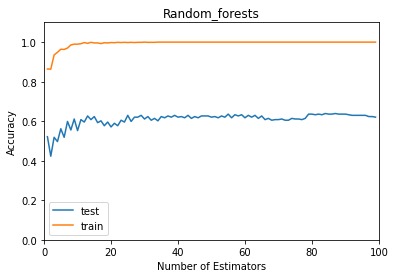

In [23]:
X=data_processed_orig.copy()
y= labels.copy()

#creating validation curve for RF
param_range=np.arange(1, 100)
train_scores, test_scores = validation_curve(
   RandomForestClassifier(random_state=0), param_name="n_estimators",
    X=X, y=y, param_range=param_range, cv=4, scoring="accuracy"
)

    
#calculate the average of the test and train scores from all folds
sum_test=np.sum(test_scores,axis=1)
sum_train=np.sum(train_scores,axis=1)
avg_test=sum_test/4
avg_train=sum_train/4


print("parameter\t","train accurary\t","test accuracy\t")

for i in range(len(param_range)):
    print(param_range[i],"\t\t",round(avg_train[i],3),"\t\t",round(avg_test[i],3),"\t")
    
    
fig, ax = plt.subplots() 

ax.set_ylim(0,1.1)
ax.set_xlim(0,100)
ax.plot(param_range,avg_test,label="test")
ax.plot(param_range,avg_train,label="train")
ax.set_xlabel('Number of Estimators')  # Add an x-label to the axes.
ax.set_ylabel("Accuracy")  # Add a y-label to the axes.
ax.set_title("Random_forests")  # Add a title to the axes.    
ax.legend()

0.6923076923076923


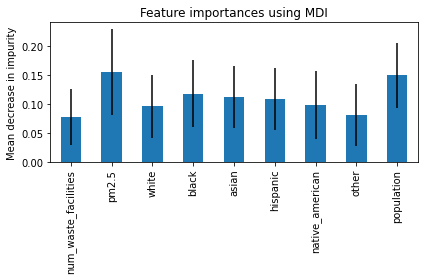

In [24]:
#we train a ideal Random Forest Classifier to find the feature importances using MDI and permutations(in next cell).

ideal_forest = RandomForestClassifier(random_state=0,n_estimators=45)
ideal_forest.fit(X_train, y_train)
print(ideal_forest.score(X_test,y_test))
importances = ideal_forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in ideal_forest.estimators_], axis=0)


forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

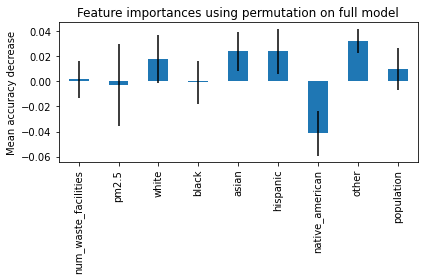

In [25]:
#we train a ideal Random Forest Classifier to find the feature importances.

result = permutation_importance(
    ideal_forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [26]:
#Create Pipeline and compute Grid Search for SVMs

def SVMPipeline(): 
    X=data.copy()
    y= labels.copy()
    steps = [('scaler', StandardScaler()), ('SVM', SVC(random_state=0))]

    pipeline = Pipeline(steps) # define the pipeline object

 
    parameters = {'SVM__C':[0.001,0.1,10,100,1000],#10e5],
                  'SVM__gamma':[0.1,0.01,0.001],
                  'SVM__kernel':['rbf', 'linear']}
   
    #we perform gridsearch on SVM
    grid = GridSearchCV(pipeline, param_grid=parameters, cv=4)
    grid.fit(X_train, y_train)
    print("score = %3.2f" %(grid.score(X_test,y_test)))
    print(grid.best_params_)


SVMPipeline()

score = 0.72
{'SVM__C': 0.1, 'SVM__gamma': 0.1, 'SVM__kernel': 'linear'}


parameter	 train accurary	 test accuracy	
1e-06 		 0.713 		 0.713 	
1e-05 		 0.713 		 0.713 	
0.0001 		 0.713 		 0.713 	
0.001 		 0.713 		 0.713 	
0.01 		 0.721 		 0.716 	
0.1 		 0.722 		 0.716 	
1 		 0.728 		 0.694 	
10 		 0.728 		 0.682 	
100 		 0.728 		 0.679 	
1000 		 0.728 		 0.679 	

	                       Feature     Weight
	          num_waste_facilities   -0.02351
	                         pm2.5   -0.00003
	                         white   -0.18777
	                         black   -0.12514
	                         asian   -0.08285
	                      hispanic    0.00085
	               native_american   -0.42865
	                         other   -0.03965
	                    population    0.03592
	                          bias    0.95198


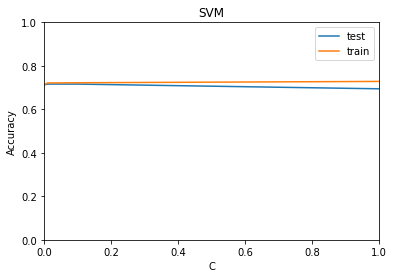

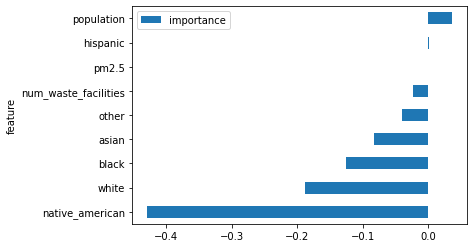

In [27]:
 #we draw validation curves for SVM using Gamma variable, and then we plot feature importances.
X=standardizer(data_processed_orig.copy())
y= labels.copy()

#create an ideal svm classifier
svm_clf = SVC(kernel='linear',gamma=0.1,random_state=0)

#validation curve
param_range=[0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000]
train,test = validation_curve(svm_clf, X, y,param_name='C',param_range=param_range,cv=4)

#calculate the average of the test and train scores from all folds
sum_test=np.sum(test,axis=1)
sum_train=np.sum(train,axis=1)
avg_test=sum_test/4
avg_train=sum_train/4

print("parameter\t","train accurary\t","test accuracy\t")
for i in range(len(param_range)):
    print(param_range[i],"\t\t",round(avg_train[i],3),"\t\t",round(avg_test[i],3),"\t")
print()

#plot validation curve
fig, ax = plt.subplots() 

ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.plot(param_range,avg_test,label="test")
ax.plot(param_range,avg_train,label="train")
ax.set_xlabel('C')  # Add an x-label to the axes.
ax.set_ylabel("Accuracy")  # Add a y-label to the axes.
ax.set_title("SVM")  # Add a title to the axes.    
ax.legend()


svm_clf.fit(X_train,y_train)
weights = list(svm_clf.coef_[0]) + list(svm_clf.intercept_) 
printWeights(X.columns,  weights)

#graph feature importance
svm_feature_importance = pd.DataFrame(X_train.columns, columns = ["feature"])
svm_feature_importance['importance']= weights[:9]
svm_feature_importance = svm_feature_importance.sort_values(by = ["importance"], ascending=True)
ax = svm_feature_importance.plot.barh(x='feature', y='importance')
plt.show()